In [64]:
import pandas as pd 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import statistics
import io

In [65]:
#information about graph:
def info(g):
    #type 
    print("type: ", type(g))
    #info
    print("info: ", nx.info(g))
    #nodes
    print("nodes: \n", g.nodes())
    #edges
    print("edges: \n", g.edges())
    #num of nodes
    print("number of nodes : ", len(g.nodes()))
    #check edges:
    print("number of edges : ", len(g.edges()))

In [66]:
#visualization:
def visual(g):
    #method 1:
    #nx.draw(g,with_labels=True,node_color='g')
    #method 2:
    plt.figure(figsize=(10,10))
    nx.draw_networkx(g)
    plt.title('My Graph!')
    plt.savefig("graph.png")
    #plt.show()

In [67]:
#compute NI:
def computeNI(g):
    max_ni = 0
    min_ni = 2 * g.number_of_nodes()
    for node in g.nodes:
        neighbors = list(g.adj[node].keys())
        triangle_num = 0
        for i in neighbors:
            for j in neighbors:
                if i < j and g.has_edge(i, j):
                    triangle_num += 1
        ni = g.degree[node] + triangle_num
        g.nodes[node]['NI'] = ni
        max_ni = max(max_ni, ni)
        min_ni = min(min_ni, ni)
    for node in g.nodes:
        g.nodes[node]['NI'] = 0.5 + 0.5 * (g.nodes[node]['NI'] - min_ni) / (max_ni - min_ni)


    data_NI = {}
    for node in sorted(g.nodes):
        #print("\nnode: ", node, "NI: ", g.nodes[node]['NI'])
        data_NI[node] = g.nodes[node]['NI']

    df_NI = pd.DataFrame(data_NI, index=['NI'])
    df_NI.to_csv('NI of the Sample Network.csv')


In [68]:
#compute SIM:
def computeSIM(g):
    #alpha = 4
    for edge in g.edges:
        u, v = edge[0], edge[1]
        # p=1
        s = 1
        # p=2
        for i in list(g.adj[u].keys()):
            if g.has_edge(i, v):
                s += 1 / 2
        # p=3
        for i in list(g.adj[u].keys()):
            for j in list(g.adj[i].keys()):
                if g.has_edge(j, v) and (not j == u):
                    s += 1 / 3
        # p=4
        for i in list(g.adj[u].keys()):
            for j in list(g.adj[i].keys()):
                for k in list(g.adj[j].keys()):
                    if g.has_edge(k, v) and (not k== u):
                        s += 1 / 4  
        for i in (u, v):
            if g.nodes[i].get('s', -1) == -1:
                g.nodes[i]['s'] = {}
        g.nodes[u]['s'][v] = s
        g.nodes[v]['s'][u] = s

    for edge in g.edges:
        u, v = edge[0], edge[1]
        for i in (u, v):
            if g.nodes[i].get('sim', -1) == -1:
                g.nodes[i]['sim'] = {}
        sim = g.nodes[u]['s'][v] / (sum(g.nodes[u]['s'].values()) * sum(g.nodes[v]['s'].values())) ** 0.5
        g.nodes[u]['sim'][v] = sim
        g.nodes[v]['sim'][u] = sim

    data_SIM = {}
    arr_SIM = []
    u_list = []
    x = 0
    for u in sorted(g.nodes):
        for v in sorted(g.nodes):
            if g.has_edge(u,v):
                #print("\nu: ", u, "v: ", v, "[u][sim][v]: ", g.nodes[u]['sim'][v])
                x = g.nodes[u]['sim'][v]
            else:
                #print("\nu: ", u, "v: ", v, "[u][sim][v]: ", 0)
                x = 0           
            arr_SIM.append(x)  
        data_SIM[u] = arr_SIM
        arr_SIM = []
        u_list.append(u)
    df_SIM = pd.DataFrame(data_SIM, index=u_list, columns=u_list)
    df_SIM.to_csv('Node Similarity Matrix of the Sample Network.csv')


In [69]:
#compute NNI:
def computeNNI(g):
    for u in g.nodes:
        g.nodes[u]['NNI'] = {}
        sim_max = max(g.nodes[u]['sim'].values())
        for v in list(g.adj[u].keys()):
            g.nodes[u]['NNI'][v] = (g.nodes[v]['NI'] * (g.nodes[u]['sim'][v] / sim_max)) ** 0.5

    data_NNI = {}
    arr_NNI = []
    u_list = []
    x = 0
    for u in sorted(g.nodes):
        for v in sorted(g.nodes):
            if g.has_edge(u,v):
                #print("\nu: ", u, "v: ", v, "[u][NNI][v]: ", g.nodes[u]['NNI'][v])
                x = g.nodes[u]['NNI'][v]
            else:
                #print("\nu: ", u, "v: ", v, "[u][NNI][v]: ", 0)
                x = 0      
            arr_NNI.append(x)    
        data_NNI[u] = arr_NNI
        arr_NNI = []
        u_list.append(u)
    df_NNI = pd.DataFrame(data_NNI, index=u_list, columns=u_list)
    df_NNI.to_csv('NNI Matrix of the Sample Network.csv')


In [70]:
#LPANNI:
def LPANNI(g, T):
    computeNI(g)
    computeSIM(g)
    computeNNI(g)
    # sort the nodes by NI & initialize
    nodes = list(g.nodes)
    v_queue = []
    for node in nodes:
        v_queue.append((node, g.nodes[node]['NI']))
        g.nodes[node]['L'] = {node: 1}
        g.nodes[node]['dominant'] = 1
        g.nodes[node]['label'] = node
    v_queue = sorted(v_queue, key=lambda v: v[1])
    nodes = [v[0] for v in v_queue]
    # label propagation
    t = 0
    while t < T:
        change=False
        for node in nodes:
            L_Ng = {}
            # Calculate the labels and weights of neighbors
            for neighbor in list(g.adj[node].keys()):
                c, b = g.nodes[neighbor]['label'], g.nodes[neighbor]['dominant'] * g.nodes[node]['NNI'][neighbor]
                if L_Ng.get(c, -1) == -1:
                    L_Ng[c] = b
                else:
                    L_Ng[c] += b
            # Remove tags with too little weight
            avg = sum(L_Ng.values()) / len(L_Ng)
            max_dominant = 0
            label = -1
            g.nodes[node]['L'] = {}
            for c in L_Ng.keys():
                if L_Ng[c] >= avg:
                    g.nodes[node]['L'][c] = L_Ng[c]
                    if L_Ng[c] > max_dominant:
                        max_dominant = L_Ng[c]
                        label = c
            sum_dominant = sum(g.nodes[node]['L'].values())
            for c in g.nodes[node]['L'].keys():
                g.nodes[node]['L'][c] /= sum_dominant
            if not g.nodes[node]['label']==label:
                g.nodes[node]['label'] = label
                change=True
            g.nodes[node]['dominant'] = max_dominant / sum_dominant
        if not change:
            break
        t += 1

    output_file = 'sample-result.txt'
    f = open(output_file, 'w')
    for node in sorted(nodes):
        print("node : ",node,"label: ", list(g.nodes[node]['L'].keys()))
        f.write(str(node) + ' ')
        for i in list(g.nodes[node]['L'].keys()):
            f.write(str(i) + ' ')
        f.write('\n')


In [71]:
#Graph Generator Class:
class GraphGenerator:
    """
    Define the threshold of the attribution coefficient
    In other words, only when the attribution coefficient of a node to a community is greater than this threshold, we will consider adding this node to the community
    """
    b_threshold = 0
    g = nx.Graph()
    def __init__(self, b, g):
        self.b_threshold = b
        self.g = g
    def get_overlapping_communities(self) -> list:
        # Return all overlapping communities from the graph
        d = {}
        for node in self.g.nodes:
            L = self.g.nodes[node]['L']
            for label in L.keys():
                if L[label] > self.b_threshold:
                    # This node belongs to the label community
                    if d.get(label, -1) == -1:
                        d[label] = {node}
                    else:
                        d[label].add(node)
        return list(d.values())
    def get_overlapping_nodes(self) -> set:
        """
        Return all overlapping nodes from the graph
        :return: all overlapping nodes
        """
        overlapping_nodes = set()
        for node in self.g.nodes:
            L = self.g.nodes[node]['L']
            count = 0
            for label in L.keys():
                if L[label] > self.b_threshold:
                    count += 1
                    if count >= 2:
                        overlapping_nodes.add(node)
                        break
        return overlapping_nodes

In [72]:

#main
def main():
    df = pd.read_csv('family.csv')
    output_file = 'community.txt'
    #edgeList:
    graph = nx.from_pandas_edgelist(df,source="From",target="To")
    choice = 1
    t = 0
    while choice != 0:
        choice = int(input("Enter your choice! 1:information 2:visualization 3:compute NI 4:compute SIM 5:compute NNI 6:result 7:Time Complexity of Algorithm 0:exit : "))
        if choice == 1:
            info(graph)
        elif choice == 2:
            visual(graph)
        elif choice == 3:
            computeNI(graph)
        elif choice == 4:
            computeSIM(graph)
        elif choice == 5:
            computeNI(graph)
            computeSIM(graph)
            computeNNI(graph)
        elif choice == 6:
            t = int(input("T: "))
            LPANNI(graph, t)
            threshold = float(input("threshold: "))
            gen = GraphGenerator(threshold, graph)
            communities = gen.get_overlapping_communities()
            f = open(output_file, 'w')
            for community in communities:
                for u in community:
                    f.write(str(u) + ' ')
                f.write('\n')
            f.flush()
            f.close()
            over_nodes = gen.get_overlapping_nodes()
            print("Overlapping Nodes: ", over_nodes)
        elif choice == 7:
            t = int(input("T: "))
            start = datetime.now()
            LPANNI(graph, t)
            distance = datetime.now() - start
            print("Time: ", str(distance.total_seconds()))

        elif choice == 8:
            t = int(input("T: "))
            LPANNI(graph, t)
        elif choice == 0:
            print("exit")
        else:
            print("Your choice is wrong! ")
          

In [73]:
"""
#main
def main():
    t_dict = {}
    for i in [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]:
        print("doc: ", i)
        df = pd.read_csv('N-%d.csv' % i) 
        output_file = 'community.txt'
        #edgeList:
        graph = nx.from_pandas_edgelist(df,source="From",target="To")
        
        choice = 1
        t = 0
        while choice != 0:
            choice = int(input("Enter your choice! 1:information 2:visualization 3:compute NI 4:compute SIM 5:compute NNI 6:result 7:Time Complexity of Algorithm 0:exit : "))
            if choice == 1:
                info(graph)
            elif choice == 2:
                visual(graph)
            elif choice == 3:
                computeNI(graph)
            elif choice == 4:
                computeSIM(graph)
            elif choice == 5:
                computeNI(graph)
                computeSIM(graph)
                computeNNI(graph)
            elif choice == 6:
                t = int(input("T: "))
                LPANNI(graph, t)
                threshold = float(input("threshold: "))
                gen = GraphGenerator(threshold, graph)
                communities = gen.get_overlapping_communities()
                f = open(output_file, 'w')
                for community in communities:
                    for u in community:
                        f.write(str(u) + ' ')
                    f.write('\n')
                f.flush()
                f.close()
                over_nodes = gen.get_overlapping_nodes()
                print("Overlapping Nodes: ", over_nodes)
            elif choice == 7:
                r = int(input("Repeat: "))
                t = int(input("T: "))
                total_time = 0
                for j in range(r):
                    start = datetime.now()
                    LPANNI(graph, t)
                    distance = (datetime.now() - start).total_seconds()
                    total_time = total_time + distance
                f_time = total_time/r
                print("Time: ", str(f_time))
                t_dict[i] = f_time
            elif choice == 0:
                print("exit")
            else:
                print("Your choice is wrong! ")

    print("time dictionary: ", t_dict)
    df_t = pd.DataFrame(t_dict, index=['Second: '])
    df_t.to_csv('Time Complexity.csv')

    plt.ylabel('time(second)')
    plt.xlabel('number of nodes')
    plt.title('Time cost of algorithm under different network nodes')
    myList = t_dict.items()
    myList = sorted(myList)
    x, y = zip(*myList)
    plt.plot(x,y, marker='o')
    plt.legend(["LPANNI"],loc="lower right")
    plt.savefig("Time Complexity.png")
    #plt.show()
""" 

'\n#main\ndef main():\n    t_dict = {}\n    for i in [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]:\n        print("doc: ", i)\n        df = pd.read_csv(\'N-%d.csv\' % i) \n        output_file = \'community.txt\'\n        #edgeList:\n        graph = nx.from_pandas_edgelist(df,source="From",target="To")\n        \n        choice = 1\n        t = 0\n        while choice != 0:\n            choice = int(input("Enter your choice! 1:information 2:visualization 3:compute NI 4:compute SIM 5:compute NNI 6:result 7:Time Complexity of Algorithm 0:exit : "))\n            if choice == 1:\n                info(graph)\n            elif choice == 2:\n                visual(graph)\n            elif choice == 3:\n                computeNI(graph)\n            elif choice == 4:\n                computeSIM(graph)\n            elif choice == 5:\n                computeNI(graph)\n                computeSIM(graph)\n                computeNNI(graph)\n            elif choice == 6:\n            

Enter your choice! 1:information 2:visualization 3:compute NI 4:compute SIM 5:compute NNI 6:result 7:Time Complexity of Algorithm 0:exit : 1
type:  <class 'networkx.classes.graph.Graph'>
info:  Graph with 115 nodes and 613 edges
nodes: 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
edges: 
 [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 14), (2, 15), (2, 7), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (3, 37), (3, 4), (3, 5), (3, 6), (3, 46), (3, 9), (3, 47), (3, 12), (3, 13), (3, 48), 

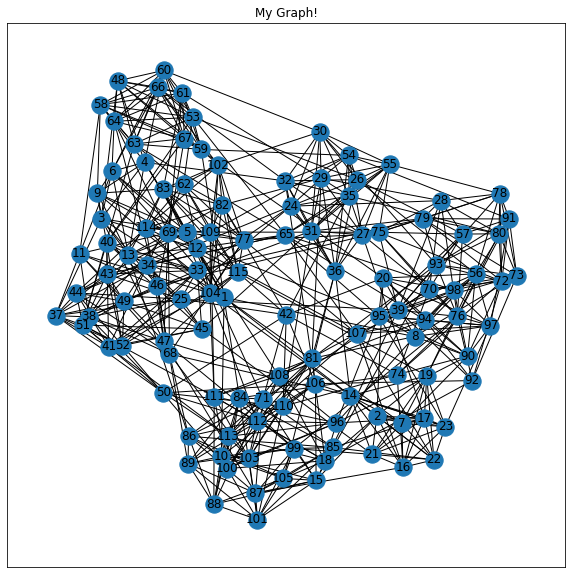

In [74]:
if __name__ == "__main__":
    main()

In [75]:
"""
from google.colab import files
uploaded = files.upload()
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n'